In [1]:
# !pip install -q tflite-model-maker

In [2]:
import os
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')

import matplotlib.pyplot as plt
import tflite_model_maker
from glob import glob
from PIL import Image, ImageOps
import re

import requests
from io import BytesIO

In [3]:
def thumbnail(image=None, desired_size=None):
    """Resizes original image as close as possible to desired size.
    Preserves aspect ratio of original image.
    Does not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image for AI model detection.
    desired_size : (width, height)
        Size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting for the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    w, h = desired_size
    try:
        # convert from numpy to native Python int type
        # that PIL expects
        if isinstance(w, np.generic):
            w = w.item()
            w = int(w)
            h = h.item()
            h = int(h)
        thumb.thumbnail((w, h))
    except Exception as e:
        msg = (f"Exception in "
                f"PIL.image.thumbnail(desired_size={desired_size}):"
                f"type(width)={type(w)}, type(height)={type(h)}"
                f"\n{e}"
                )
        
        raise RuntimeError(msg)
    
    return thumb


def resize(image=None, desired_size=None):
    """Pad original image to exact size expected by input tensor.
    Preserve aspect ratio to avoid confusing the AI model with
    unnatural distortions. Pad the resulting image
    with solid black color pixels to fill the desired size.
    Do not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image sized to fit an input tensor but without padding.
        Its possible that one size fits one tensor dimension exactly
        but the other size is smaller than
        the input tensor other dimension.
    desired_size : (width, height)
        Exact size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting exactly the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    delta_w = desired_size[0] - thumb.size[0]
    delta_h = desired_size[1] - thumb.size[1]
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(thumb, padding)
    
    assert new_im.size == desired_size
    return new_im

# Person Detect model

In [4]:
person_interpreter = tf.lite.Interpreter(model_path="ai_models/mobilenet_ssd_v2_coco_quant_postprocess.tflite")


def load_labels(label_path=None):
    
    p = re.compile(r'\s*(\d+)(.+)')
    with open(label_path, 'r', encoding='utf-8') as f:
        lines = (p.match(line).groups() for line in f.readlines())
        return {int(num): text.strip() for num, text in lines}
        
_labels = load_labels('ai_models/coco_labels.txt')

_label_filter = ['person']

In [5]:
def detect(image=None, person_confidence_threshold=0.6):

    person_interpreter.allocate_tensors()

    input_details = person_interpreter.get_input_details()
    output_details = person_interpreter.get_output_details()

    width, height = input_details[0]['shape'][1], input_details[0]['shape'][2]

    desired_size = (width, height)

    thumbnail_ = thumbnail(image=image, desired_size=desired_size)
    new_im = resize(image=thumbnail_, desired_size=desired_size)
    
    
    w_factor = thumbnail_.size[0] / new_im.size[0]
    h_factor = thumbnail_.size[1] / new_im.size[1]

    input_data = np.expand_dims(new_im, axis=0)

    person_interpreter.set_tensor(input_details[0]['index'], input_data)
    person_interpreter.invoke()

    boxes = person_interpreter.get_tensor(output_details[0]['index'])
    label_codes = person_interpreter.get_tensor(output_details[1]['index'])   
    scores = person_interpreter.get_tensor(output_details[2]['index'])
    num = person_interpreter.get_tensor(output_details[3]['index'])
    
    detections_count = int(num[0])

    inference_result = []
    indices_of_sorted_scores = np.argsort(scores[0, :detections_count])
    
    top_k = 10
    top_k_indices = indices_of_sorted_scores[-1*top_k:][::-1]
    
    for i in top_k_indices:
        confidence = scores[0, i]
        if confidence >= person_confidence_threshold:
            
            li = int(label_codes[0, i])
            if (li < len(_labels)):
                label = _labels[li]
                
                if (not _label_filter or label in _label_filter):
                    x = boxes[0, i, [1, 3]] * new_im.size[0]
                    y = boxes[0, i, [0, 2]] * new_im.size[1]
                    rectangle = [x[0], y[0], x[1], y[1]]
                    inference_result.append((
                        label,
                        confidence,
                        rectangle))
    return thumbnail_, new_im, inference_result


In [6]:
def get_crop_person(img_path, is_url):
    
    if is_url:
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(img_path)

    original_shape = img.size
    thumbnail_, new_im, inference_result = detect(img)
    cropped_img_list = []
    
    for i in range(len(inference_result)):

        rectangle = (inference_result[i][2][0],inference_result[i][2][1], inference_result[i][2][2],inference_result[i][2][3])
        rectangle = list(rectangle)

        MAX = 300
        new_h,new_w = (MAX/max(original_shape[1],original_shape[0]))*(original_shape[1]), (MAX/max(original_shape[1],original_shape[0]))*(original_shape[0])

        h_ratio = original_shape[1]/new_h
        w_ratio = original_shape[0]/new_w
        
        og_rec = [rectangle[0]*w_ratio, rectangle[1]*h_ratio, rectangle[2]*w_ratio, rectangle[3]*h_ratio]

        cropped_image = img.crop((og_rec[0], og_rec[1], og_rec[2], og_rec[3]))
        cropped_img_list.append(cropped_image)

    return cropped_img_list, img

In [7]:
img_path = "Images/fall_img_1.png"
cropped_image_list, img = get_crop_person(img_path, is_url=False)

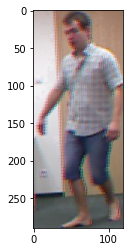

In [8]:
plt.imshow(cropped_image_list[0])

# Execute Fall Detect

In [9]:
fall_interpreter = tf.lite.Interpreter(model_path="ai_models/tflite-model-maker-falldetect-model-2oct.tflite")

In [10]:
def fall_prediction(path_image, is_url=False):
    
    fall_interpreter.allocate_tensors()

    input_details = fall_interpreter.get_input_details()
    output_details = fall_interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    width, height = input_details[0]['shape'][1], input_details[0]['shape'][2]

    cropped_image_list, ori_img = get_crop_person(path_image, is_url)
    pred = ""
    
    if len(cropped_image_list) == 0:
        return "no detection"

        
    temp_result = []
    temp_result.append([ori_img, 'ori_image'])
    
    for template_image_src in cropped_image_list:
                
        _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
        resize_img = resize(image=_thumbnail, desired_size=(width, height))
                
        img = np.expand_dims(resize_img,0)

        fall_interpreter.set_tensor(input_details[0]['index'], img)
        fall_interpreter.invoke()
        output_data = fall_interpreter.get_tensor(output_details[0]['index'])
    
        pred = "fall" if np.argmax(output_data[0])==0 else "no-fall"        
        temp_result.append([resize_img, pred])
        
    plot_result(temp_result)
    
            
    return pred

In [11]:
def plot_result(result):
    
        
    frame_to_display = len(result) 
    columns = 6
    rows = (frame_to_display // columns) + 1
    
    fig = plt.figure(figsize=(20, 28))

    plt_cnt = 1

    for image, pred in result:
                
        fig.add_subplot(rows, columns, plt_cnt)
        plt.axis("off")
        
        plt_title = pred

        plt.title(plt_title)        
        plt.imshow(image)

        plt_cnt += 1

# Prediction on Single Image

'no-fall'

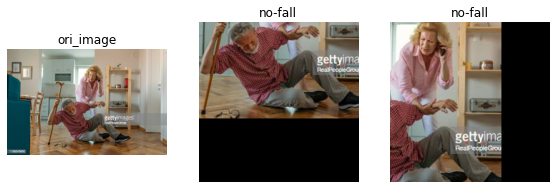

In [12]:
path_image = "Images/2-person.jpg"
pred = fall_prediction(path_image)
pred

# Prediction on Multiple Image

<ipython-input-11-8d2d1612dad3>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 28))


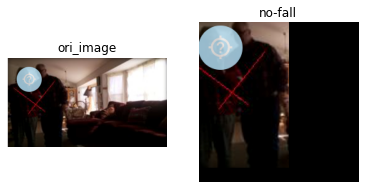

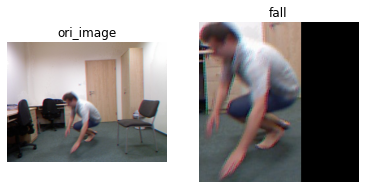

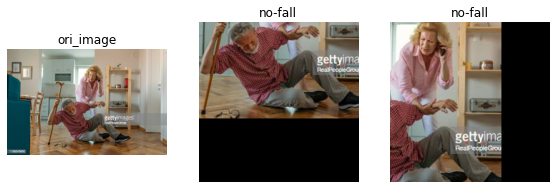

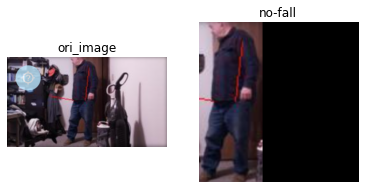

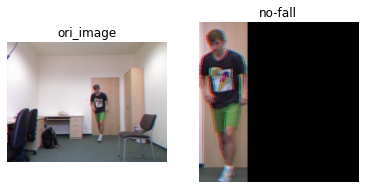

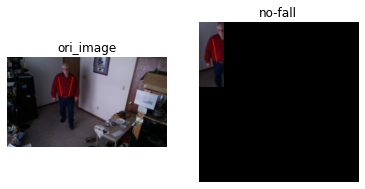

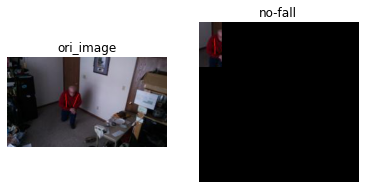

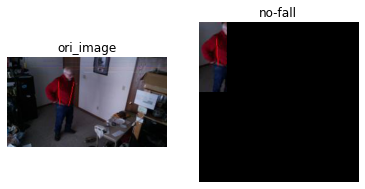

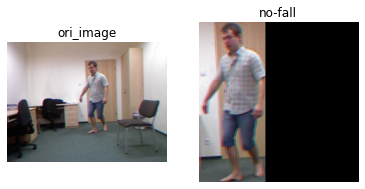

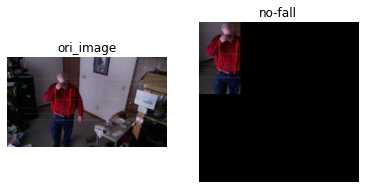

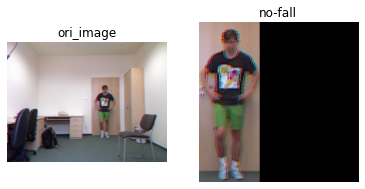

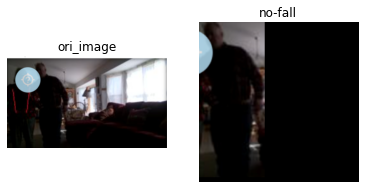

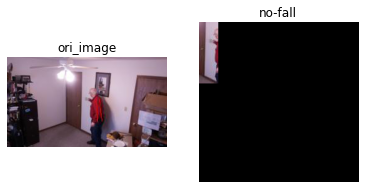

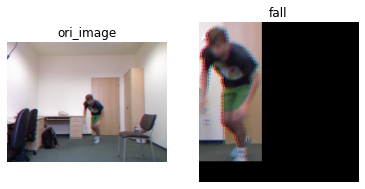

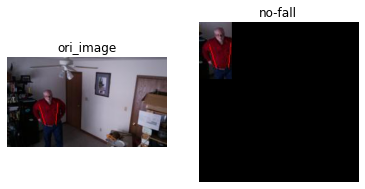

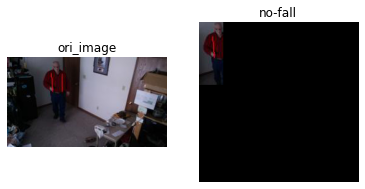

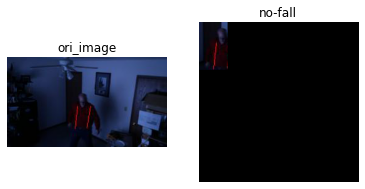

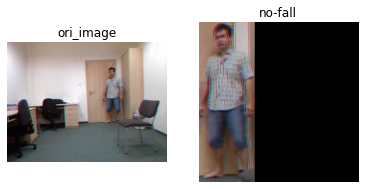

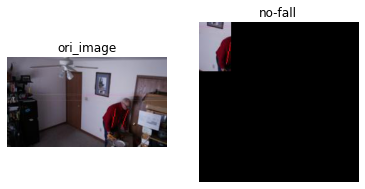

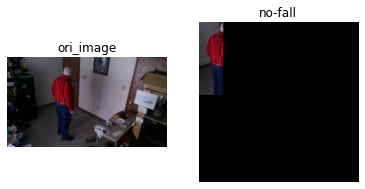

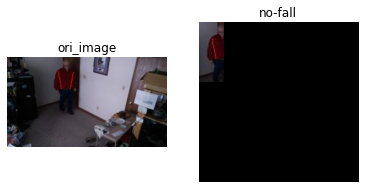

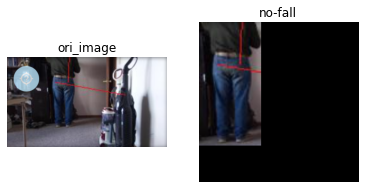

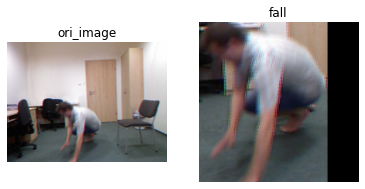

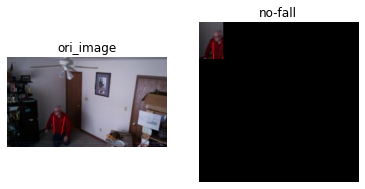

In [13]:
def pred_for_dir(image_list):
    
    image_list = os.listdir('Images/')
    
    for i in image_list:
        pred = fall_prediction('Images/'+i)
                
pred_for_dir('Images/')

# Prediction using URL

Enter URL->https://cdn.shopify.com/s/files/1/0307/4061/1203/articles/if-elderly-fall.jpg?v=1616492775


'no-fall'

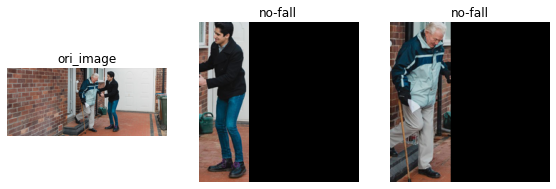

In [17]:
def predict_from_url(url):

    pred = fall_prediction(url, is_url=True)    
    return pred

predict_from_url(input('Enter URL->'))

In [ ]:
# https://www.brightstarcare.com/BSC/media/images/Corporate/male-caregiver-helping-senior-man-up-stairs.png